# Stellar Structure Project

In [170]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.constants as const
from scipy.integrate import solve_ivp
from scipy.interpolate import interpn


## Step 1: Equation of state

In your programming language of choice, please write your own function to calculate density ρ given pressure P, temperature T, 
and composition X, Y, and Z (i.e., the equation of state). Your function should assume complete ionization and include the
effect of radiation pressure. Then please:

1. calculate ρ for plasma with X = 0, Y = 0.98, log10(T/K) = 7.55, and log10(P/dyne) = 16.85;
2. calculate ρ for plasma with X = 0.70, Y = 0.28, log10(T/K) = 6.91, and log10(P/dyne) = 16.87; and
3. in both cases (1) and (2), calculate the ratio of the gas pressure to total pressure β.

In [290]:
# Equation of state

def equation_of_state(P, T, X, Y, Z):
    '''
    Equation of state of an ideal monatomic gas in LTE assuming complete ionization and including radiation pressure.

    Input parameters:
        P: pressure (dyne/cm^2)
        T: temperature (K)
        X, Y, Z: composition (H, He, metals)
    
    Returns:
        rho: density (g cm^-3)
    '''
    a = 7.56*10**(-15)*u.erg/u.cm**(3)/u.K**(4) # radiation density constant
    Na = const.N_A.cgs
    k = const.k_B.cgs

    # calculate radiation pressure from T - assuming a blackbody
    Prad = ((1/3)*a*T**4)
    Pgas = P - Prad

    # calculate mean molecular weight from composition
    mu = (4/(3 + 5*X)*u.u).to(u.g/u.mol, equivalencies=u.molar_mass_amu()) # eq 1.55 - assumes Z << 1 and complete ionization
    
    rho = (Pgas*mu/(Na*k*T)).to(u.g/u.cm**3)

    return rho, Pgas

In [47]:
# 1. X = 0, Y = 0.98, log10(T/K) = 7.55, and log10(P/dyne) = 16.85 - should P be per cm^2?

P_1 = (10**(16.85))*u.dyne/u.cm**2
T = (10**(7.55))*u.K

rho, Pgas_1 = equation_of_state(P_1, T, 0, 0.98, 0.02)
rho

<Quantity 30.1915371 g / cm3>

In [48]:
# 2. X = 0.7, Y = 0.28, log10(T/K) = 6.91, and log10(P/dyne) = 16.87 - should P be per cm^2?

P_2 = (10**(16.87))*u.dyne/u.cm**2
T = (10**(6.91))*u.K

rho, Pgas_2 = equation_of_state(P_2, T, 0.7, 0.28, 0.02)
rho

<Quantity 67.49133217 g / cm3>

In [ ]:
# in both cases (1) and (2), calculate the ratio of the gas pressure to total pressure β

beta_1 = Pgas_1/P_1
beta_2 = Pgas_2/P_2

print(r'For Case 1: Beta = ' + beta_1.to_string())
print(r'For Case 2: Beta = ' + beta_2.to_string())

For Case 1: $\Beta$ = 0.9435842273080781
For Case 2: $\Beta$ = 0.9998516113988505


## Step 2: Opacity

In your programming language of choice, please write your own function (possibly calling an existing interpolation routine) to
interpolate an opacity table and calculate opacity κ for specific values of density ρ and temperature T in log10(ρ) and 
log10(T) space. Your function should work over the intervals −9 < log10(ρ/g cm-3) < 3 and 3.75 < log10(T/K) < 7.5. Then for 
X = 0.70 and Y = 0.28 please:

1. calculate κ for log10(ρ/g cm-3) = 0.3 and log10(T/K) = 6.3
2. calculate κ for log10(ρ/g cm-3) = -4 and log10(T/K) = 5

In [291]:
def opacity(table, rho, T):
    '''
    Interpolate opacity table and calculate opacity for a given density and temperature.

    Input parameters:
        table: opacity table to interpolate - chosen for a given composition
        rho: log10 density (unitless - 10^rho: g cm^-3)
        T: log10 temperature (unitless - 10^T: K)
        X, Y: composition (H, He)
    
    Returns:
        kappa: opacity (g cm^-2)
    '''
    # opacity tables reference log R not rho
    R = np.log10(10**(rho)/(10**(T)/10**6)**3)

    # make 2D grid covering logR - logT space
    Ts = np.array(table[1:,0])
    Rs = np.array(table[0,1:])
    points = (Ts, Rs)
    grid = np.meshgrid(Ts, Rs)

    # grab table values in grid
    values = table[1:,1:]

    # print('T = ' + str(T))
    # print('R = ' + str(R))

    if T > np.max(Ts): 
        print('T too large, T = ' + str(T))
        T = np.max(Ts)
    elif T < np.min(Ts): 
        print('T too small, T = ' + str(T))
        T = np.min(Ts)
    if R > np.max(Rs):
        print('R too large, R = ' + str(R))
        R = np.max(Rs)
    elif R < np.min(Rs):
        print('R too small, R = ' + str(R))
        R = np.min(Rs)
        
    # interpolate over grid and evaluate at given point
    kappa = interpn(points, values, np.array([T, R]))

    return (10**kappa) * u.cm**2 / u.g


In [56]:
# opacity table for X = 0.7 and Y = 0.28
tab = np.loadtxt('opacity_X0.7_Y0.28.rtf')
np.meshgrid(tab[0,1:], tab[1:,0])[1].shape
tab[1:,0].shape

(50,)

In [61]:
# 1: log10(ρ/g cm-3) = 0.3 and log10(T/K) = 6.3

rho = 0.3
T = 6.3

kappa = opacity(tab, rho, T)[0]

print(r'kappa = ' + str(kappa))

kappa = 73.06732363988856 cm2 / g


In [58]:
# 2: log10(ρ/g cm-3) = -4 and log10(T/K) = 5

rho = -4
T = 5

kappa = opacity(tab, rho, T)[0]

print(r'kappa = ' + str(kappa))

kappa = 2740.2078438087456 cm2 / g


Text(0.5, 1.0, 'Opacity vs Temp for X = 0.7, Y = 0.28')

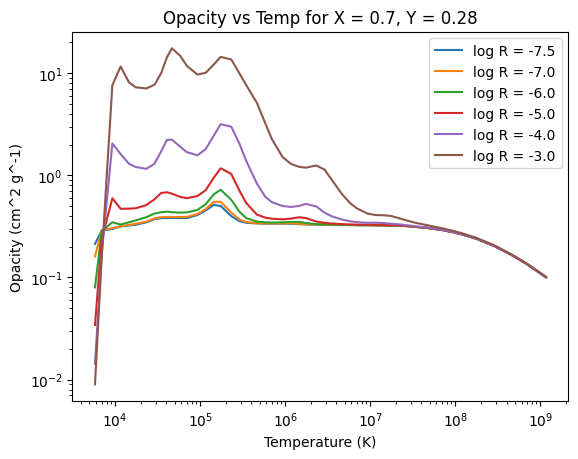

In [53]:
import matplotlib.pyplot as plt

Ts = tab[1:,0]

Rs = tab[0,1:]

for i in [1,2,4,6,8,10]: 
    # rho = 10**R * 10**6 * 10**(Ts[i])
    kappas = 10**(tab[1:,i])
    plt.loglog(10**(Ts), kappas, label='log R = ' + str(Rs[i]))

plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Opacity (cm^2 g^-1)')
plt.title('Opacity vs Temp for X = 0.7, Y = 0.28')

## Step 3: Nuclear Energy Generation

In your programming language of choice, please write your own function to
calculate nuclear energy generation rate ε in ergs g-1 s-1 from hydrogen fusion
as a function of density ρ, temperature T, and composition (X, Y, and Z)
accounting for both the proton—proton chains and CNO cycles assuming the
reactions have reached equilibrium. You should use the approximations
given in Chapter 18 of Stellar Structure and Evolution (Second Edition). Be
sure to use weak screening for f11. Then please calculate the ratio of the
energies generated by the pp chains and CNO cycles for X = 0.70, Y = 0.28,
log10(ρ/g cm-3) = 1.90, and log10(T/K) = 7.25.


In [310]:
def epsilon(rho, T, X, Y, Z):
    '''
    Calculate energy generation rate for pp-chain and CNO assuming reactions are in equilibrium.

    Input parameters:
        rho: log10 density (unitless - 10^rho: g cm^-3)
        T: log10 temperature (unitless - 10^T: K)
        X, Y, Z: composition (H, He, metals)
    
    Returns:
        epsilon_pp, epsilon_cno: energy generation rate (ergs g^-1 s^-1)
    '''
    T_9 = 10**T / 10**9 
    rho = 10**rho 

    # assuming psi = 1 (no appreciable helium)
    g_11 = 1 + 3.82*T_9 + 1.51*T_9**2 + 0.144*T_9**3 - 0.0114*T_9**4
    f_11 = np.exp(5.92*10**-3 * (rho/(T_9*10**2)**(1/2)))
    e_pp = 2.57*10**4 * f_11 * g_11 * rho * X**2 * T_9**(-2/3)*np.exp(-3.381/T_9**(1/3))

    # eq 18.65 assuming X_CNO = Z
    g_14_1 = 1 - 2*T_9 + 3.41*T_9**2 - 2.43*T_9**3
    e_cno = 8.24*10**25 * g_14_1 * Z * X * rho * T_9**(-2/3) * np.exp(-15.231*T_9**(-1/3) - (T_9/.8)**2)
     
    return e_pp * u.erg/u.g/u.s, e_cno * u.erg/u.g/u.s

In [313]:
e_pp, e_cno = epsilon(1.9, 7.25, .7, .28, .02)

print('e_pp/e_cno = ' + str(e_pp/e_cno))

e_pp/e_cno = 0.8957779597813859


## Step 4: Initial Boundary Conditions

In your programming language of choice, please write two functions load1
and load2 described in the documentation for shootf in the stellar
structure calculation instructions. The function load1 should give the
values of the four dependent variables l, P , r, and T at a mass point m very
slightly away from the center of the star for use as initial values of outward
integrations. The function load2 should give the same four dependent
variables at the surface for use as initial values of inward integrations. Note
that the central pressure Pc, central temperature Tc, total luminosity L*, and
total radius R* are parameters for which you must provide an initial guess.

In [296]:
def load1(M, Pc, Tc, X, Y, Z, table):
    """
    Give the values of the four dependent variables l, P , r, and T at a mass 
    point m very slightly away from the center of the star for use as initial 
    values of outward integrations. 

    Input parameters:
        M: total mass of star
        Pc = initial guess for central pressure
        Tc = initial guess for central temperature
        
    """
    # constants
    a = 7.56*10**(-15)*u.erg/u.cm**(3)/u.K**(4) # radiation density constant
    c = const.c.cgs
    G = const.G.cgs

    # calculate mass to use for inner bound (very small fraction of total mass)
    m = 10**(-10)*M

    # calculate central density
    rho_c = equation_of_state(Pc, Tc, X, Y, Z)[0]

    # in luminosity equation, I don't think I need it
    # e_g = 

    # get opacity
    kappa_c = opacity(table, np.log10(rho_c.value), np.log10(Tc.value))[0]

    # calculate energy generation
    e_pp, e_cno = epsilon(np.log10(rho_c.value), np.log10(Tc.value), X, Y, Z)
    l = (e_pp + e_cno) * m # eq. 11.4

    r = m**(1/3) * (1/(4*np.pi*rho_c)**(1/3)) # eq 11.3
    P = Pc - 3*G/(8*np.pi) * (4*np.pi*rho_c/3)**(4/3) * m**(2/3) # eq. 11.6
    T = (Tc**4 - 1/(2*a*c) * (3/(4*np.pi))**(2/3) * kappa_c * (e_pp + e_cno) * rho_c**(4/3) * m**(2/3))**(1/4) 
    # eq. 11.9 - radiative case (true for core of 2-3 solar mass star)
    return l, P, r, T

def load2(M, L_star, R_star, Pc, Tc, X, Y, Z, table): #, Pc, Tc, X, Y, Z, table
    """
    The function load2 should give the same four dependent variables at the 
    surface for use as initial values of inward integrations. Note that the 
    central pressure Pc, central temperature Tc, total luminosity L*, and 
    total radius R* are parameters for which you must provide an initial guess.

    Input parameters:
        M: total mass of star
        L_star: initial guess for total luminosity
        R_star: initial guess for total radius
        Pc: initial guess for central pressute
        Tc: initial guess for central temperature
    """
    # constants
    a = 7.56*10**(-15)*u.erg/u.cm**(3)/u.K**(4) # radiation density constant
    c = const.c.cgs
    G = const.G.cgs
    sigma = a*c/4

    # take r and l from initial guesses
    l = L_star
    r = R_star

    # for this shell, m = M
    m = M

    # T = T_eff
    T = (l/(4*np.pi * r**2 * sigma))**(1/4) # eq. 11.14

    # get opacity at photosphere - use kappa in core as initial guess
    rho_c, P_gas = equation_of_state(Pc, Tc, X, Y, Z) # define in terms of central density for initial guess
    kappa = opacity(table, np.log10(rho_c.value), np.log10(Tc.value))[0]

    # get opacity from eddington limit
    # kappa = ((4*np.pi*G*c*m)/l).to(u.cm**2 / u.g)

    # use opacity for thompson scattering
    # kappa = 0.2*(1 + X) * u.cm**2 / u.g
    
    # pressure at photosphere
    P = (2*G*m/(3*r**2*kappa)).to(u.dyne / u.cm**2) # eq. 11.13
    return l, P, r, T

In [108]:
print(const.G.cgs)

6.674299999999999e-08 cm3 / (g s2)


## Step 5: Derivatives
In your programming language of choice, please the function derivs
described in the documentation for shootf in the stellar structure
calculation instructions. The function derivs should take the independent
variable m and the four dependent variables l, P , r, and T and return the
derivatives dl/dm, dP/dm, dr/dm, and dT /dm. Then please calculate these
derivatives at the inner and outer boundaries.


In [ ]:
def derivs(m, vars, X, Y, Z, table, outer=False):
    # constants
    a = 7.56*10**(-15)*u.erg/u.cm**(3)/u.K**(4) # radiation density constant
    c = const.c.cgs
    G = const.G.cgs

    m = m * u.g

    # unpack variables
    l, P, r, T = vars
    l = l * u.erg/u.s
    P = P * u.dyne/u.cm**2
    r = r * u.cm
    T = T * u.K

    # calculate the density, opacity and energy generation rates
    rho_m = equation_of_state(P, T, X, Y, Z)[0]
    print('P = ' + str(P))
    print('T = ' + str(T))
    print('rho_m = ' + str(rho_m))
    e_pp, e_cno = epsilon(np.log10(rho_m.value), np.log10(T.value), X, Y, Z)
    kappa = opacity(table, np.log10(rho_m.value), np.log10(T.value))[0]

    # determine what nabla to use
    nabla_rad = 3*P*l*kappa/(16*np.pi*a*c*G*m*T**4)
    nabla_ad = .4 # for an ideal gas with gamma = 5/3

    nabla = min(nabla_ad, nabla_rad)

    # 4 coupled ODEs
    dl_dm = e_pp + e_cno
    dP_dm = -G*m/(4*np.pi*r**4)
    dr_dm = 1/(4*np.pi*r**2*rho)
    dT_dm = -G*m*T/(4*np.pi*r**4*P) * nabla

    if outer:
        print([l.value, P.value, r.value, T.value])
        print([-dl_dm.value, -dP_dm.value, -dr_dm.value, -dT_dm.value])
        return [-dl_dm.value, -dP_dm.value, -dr_dm.value, -dT_dm.value]
    else:
        return [dl_dm.value, dP_dm.value, dr_dm.value, dT_dm.value]

In [130]:
# properties of star
M = 2*10**33 * u.g # solar masses
X = 0.7
Y = 0.28
Z = 0.02
table = np.loadtxt('opacity_X0.7_Y0.28.rtf')

# define initial guesses
Pc = 2.5*10**17 * u.dyn/u.cm**2 # central pressure
Tc = 2*10**7 * u.K # central temperature
L_star = 4*10**33 * u.erg/u.s # total luminosity
R_star = 10**10 * u.cm # total radius

# load parameters at inner boundary and compute derivatives
l, P, r, T = load1(M, Pc, Tc, X, Y, Z, table)
print('Inner Boundary Conditions:\n l = ' + str(l) + '\n P = ' + str(P) + '\n r = ' + str(r) + '\n T = ' + str(T))
dl_dm, dP_dm, dr_dm, dT_dm = derivs(M, l, P, r, T, X, Y, Z, table)
print('Inner Boundary Derivatives:\n dl/dm = ' + str(dl_dm) + '\n dP/dm = ' + str(dP_dm) + '\n dr/dm = ' + str(dr_dm) + '\n dT/dm = ' + str(dT_dm))

# load parameters at outer boundary and compute derivatives
l, P, r, T = load2(M, L_star, R_star, Pc, Tc, X, Y, Z, table)
print('Outer Boundary Conditions:\n l = ' + str(l) + '\n P = ' + str(P) + '\n r = ' + str(r) + '\n T = ' + str(T))
dl_dm, dP_dm, dr_dm, dT_dm = derivs(M, l, P, r, T, X, Y, Z, table)
print('Outer Boundary Derivatives:\n dl/dm = ' + str(dl_dm) + '\n dP/dm = ' + str(dP_dm) + '\n dr/dm = ' + str(dr_dm) + '\n dT/dm = ' + str(dT_dm))

Inner Boundary Conditions:
 l = 1.2395928145505173e+26 erg / s
 P = 2.4999992318361165e+17 dyn / cm2
 r = 5564586.377045009 cm
 T = 19999980.954899978 K
6
7
8
9
Inner Boundary Derivatives:
 dl/dm = 619.7865696574003 erg / (g s)
 dP/dm = -0.011078840310140933 1 / (cm s2)
 dr/dm = 8.566493799343576e-15 1 / cm2
 dT/dm = -2.7467870392616248e-22 K cm / (dyn s2)
Outer Boundary Conditions:
 l = 4e+33 erg / s
 P = 1097180.1752304223 dyn / cm2
 r = 10000000000.0 cm
 T = 15395.432894029524 K
6
7
8
9
Outer Boundary Derivatives:
 dl/dm = 8.072152369902103e-66 erg / (g s)
 dP/dm = -1.062247836678237e-15 1 / (cm s2)
 dr/dm = 2.652582384864922e-21 1 / cm2
 dT/dm = -5.962107466250317e-18 K cm / (dyn s2)


## Step 6: Shootf Function

In [311]:
def check_nabla(t, y, X, Y, Z, table, outer):
    # constants
    a = 7.56*10**(-15)*u.erg/u.cm**(3)/u.K**(4) # radiation density constant
    c = const.c.cgs
    G = const.G.cgs

    print('reached nabla_check')

    m = t * u.g

    # unpack variables
    # l, P, r, T = vars
    l = y[0] * u.erg/u.s
    P = y[1] * u.dyne/u.cm**2
    # r = r * u.cm
    T = y[3] * u.K

    rho_m = equation_of_state(P, T, X, Y, Z)[0]
    kappa = opacity(table, np.log10(rho_m.value), np.log10(T.value))[0]

    nabla_rad = 3*P*l*kappa/(16*np.pi*a*c*G*m*T**4)

    return (nabla_rad - 0.4).value # finding roots where these are equal
check_nabla.terminal = True

def neg_values(t, y, X, Y, Z, table, check):
    neg_values.terminal = True
    neg_values.direction = -1
    return y


def shootf(M, Pc, Tc, R_star, L_star, X, Y, Z, table):
    # load inner and outer boundary conditions
    l_i, P_i, r_i, T_i = load1(M, Pc, Tc, X, Y, Z, table)
    l_o, P_o, r_o, T_o = load2(M, L_star, R_star, Pc, Tc, X, Y, Z, table)

    # integrate inner boundaries out and outer boundaries in
    # sol_inner = solve_ivp(derivs, (10**(-10)*M.value, M.value), [l_i.value, P_i.value, r_i.value, T_i.value], args=(X,Y,Z,table))
    # print(4)
    check_nabla.direction = 1 # terminate when nabla_rad > nabla_ad
    sol_outer = solve_ivp(derivs, [M.value, .5*M.value], [l_o.value, P_o.value, r_o.value, T_o.value], 
                          args=(X,Y,Z,table,True), events=neg_values)
    
    return sol_outer


In [315]:
# properties of star
M = 2*10**33 * u.g # solar masses
X = 0.7
Y = 0.28
Z = 0.02
table = np.loadtxt('opacity_X0.7_Y0.28.rtf')

# define initial guesses
Pc = 2.5*10**17 * u.dyn/u.cm**2 # central pressure
Tc = 2*10**7 * u.K # central temperature
L_star = 1.3*10**32 * u.erg/u.s # total luminosity
R_star = 10**10 * u.cm # total radius

sol_inner = shootf(M, Pc, Tc, R_star, L_star, X, Y, Z, table)

P = 1097180.1752304223 dyn / cm2
T = 6536.763090799449 K
rho_m = 1.2422981398351705e-06 g / cm3
[1.3e+32, 1097180.1752304223, 10000000000.0, 6536.763090799449]
[-1.3171982409911993e-77, 1.062247836678237e-15, -2.652582384864922e-21, 2.5314574976244354e-18]
P = 1097180.1752304223 dyn / cm2
T = 6536.763090799449 K
rho_m = 1.2422981398351705e-06 g / cm3
[1.3e+32, 1097180.1752304223, 10000000000.0, 6536.763090799449]
[-1.3171982409911993e-77, 1.062247836678237e-15, -2.652582384864922e-21, 2.5314574976244354e-18]
P = 1096567.831043358 dyn / cm2
T = 6535.303804905944 K
rho_m = 1.2418820473451379e-06 g / cm3
[1.3e+32, 1096567.831043358, 10000000000.00153, 6535.303804905944]
[-1.2993483129112652e-77, 1.0622478366775867e-15, -2.652582384864111e-21, 2.5323056658289484e-18]
P = 1096261.6589498264 dyn / cm2
T = 6534.5736119065505 K
rho_m = 1.241674035928937e-06 g / cm3
[1.3e+32, 1096261.6589498264, 10000000000.002295, 6534.5736119065505]
[-1.2905058472147496e-77, 1.0622478366772613e-15, -2.6525823

/var/folders/q4/x7n1mn456xz8y840vd4fhdd00000gn/T/ipykernel_52394/1172036903.py:21: RuntimeWarning: invalid value encountered in log10
  e_pp, e_cno = epsilon(np.log10(rho_m.value), np.log10(T.value), X, Y, Z)
/var/folders/q4/x7n1mn456xz8y840vd4fhdd00000gn/T/ipykernel_52394/1172036903.py:22: RuntimeWarning: invalid value encountered in log10
  kappa = opacity(table, np.log10(rho_m.value), np.log10(T.value))[0]


ValueError: One of the requested xi is out of bounds in dimension 0

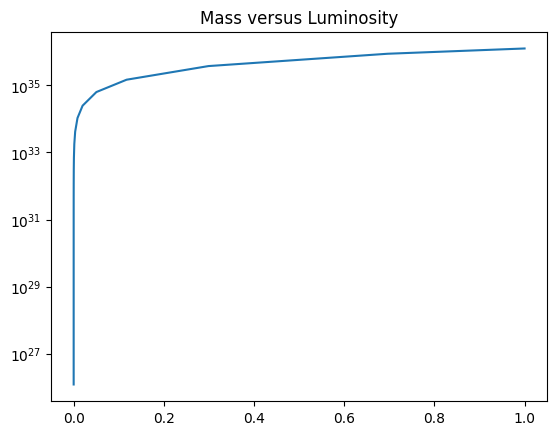

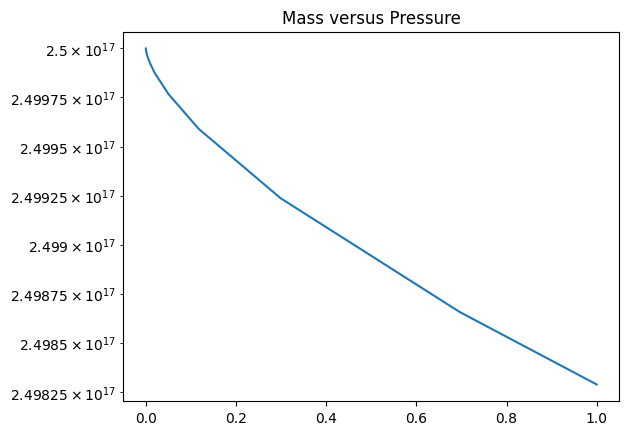

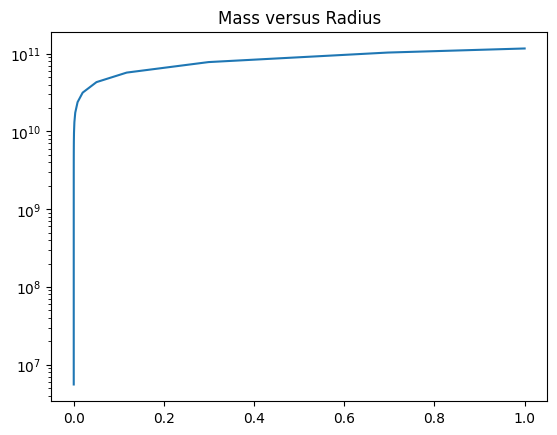

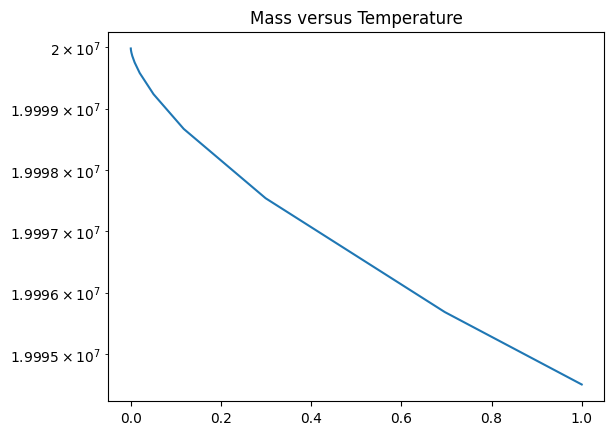

In [284]:
sol_inner.y[0]

plt.plot(sol_inner.t/M.value, sol_inner.y[0])
plt.title('Mass versus Luminosity')
plt.yscale('log')
plt.show()

plt.plot(sol_inner.t/M.value, sol_inner.y[1])
plt.title('Mass versus Pressure')
plt.yscale('log')
plt.show()

plt.plot(sol_inner.t/M.value, sol_inner.y[2])
plt.title('Mass versus Radius')
plt.yscale('log')
plt.show()

plt.plot(sol_inner.t/M.value, sol_inner.y[3])
plt.title('Mass versus Temperature')
plt.yscale('log')
plt.show()

In [ ]:
# rent
rent = 2400

# cat
pet_fee = 250
pet_rent = 30 # per pet

# parking
two_car = 220
one_car = 130

# ammenities
ammenity = 100

# gas/electric - gas is shared throughout building
bge = 100

# water/sewage
water = 100

# security deposit
deposit = 300

tot_per_month = rent + pet_rent + two_car + bge + water
tot_fees = pet_fee + ammenity + deposit

print('Rent per person with cars: ' + str(tot_per_month/2))
print('Rent per person no cars: ' + str((tot_per_month - two_car)/2))
print('One time fees per person: ' + str(tot_fees/2))

Rent per person with cars: 1425.0
Rent per person no cars: 1315.0
One time fees per person: 325.0
